# BINF TP3 - Algorithmes d'alignement par paire

Dans ce TP nous allons manipuler les algorithmes d'alignement par paire.

# Exercice 0 - Echauffement

Q1. Donnez le score de la superposition :

|       |       |
| :---: | :---: |
x       | ATGTCATGA---TAC |
y       | AT--CTAAATGTTAC |


étant donne le schéma d'évaluation :

|       | A     | T     | G     | C     |
| :---: | :---: | :---: | :---: | :---: |
| **A** | 1     | -1    | -1    | -1    |
| **T** | -1    | 1     | -1    | -1    |
| **G** | -1    | -1    | 1     | -1    |
| **C** | -1    | -1    | -1    | 1     |

et

$\gamma(g) = 0.5 |g| + 0.5$

```markdown
Le score de la superposition est 1+1-1.5-1.5+1-1-1-1+1-1.5-1.5-1.5+1+1+1=-3.5
```

Q2. Alignez les séquences suivantes avec l'algorithme de Levenshtein :  x = ATG et y = ACTG.

```markdown
La distance de Levenshtein entre les séquences x=ATG et y=ACTG est 1.
```

Q3.	Alignez les séquences suivantes avec l'algorithme de Needleman-Wunsch global x = TAT et y = ATGAC en considérant le schéma d'évaluation suivant

|       | A       | T       | G       | C     |
| :---: | :---:   | :---:   | :---:   | :---: |
| **A** | 1       | -0.5    | -0.5    | -0.5  |
| **T** | -0.5    | 1       | -0.5    | -0.5  |
| **G** | -0.5    | -0.5    | 1       | -0.5  |
| **C** | -0.5    | -0.5    | -0.5    | 1     |

et

$\gamma(g) = 0.5 |g|$


```markdown
Le score d'alignement entre les séquences x=TAT et y=ATGAC est 4.
```

Q4. Alignez les séquences suivantes avec l'algorithme de Smith-Waterman x = TTGG y = ATGAC en utilisant le schéma d'évaluation de la question précédente.


```markdown
Le score d'alignement entre les séquences x=TTGG et y=ATGAC est 2.
```

# Exercice 1 : Algorithme de Levenshtein - version récursive

Q1. Ecrivez une fonction

levenshtein(x: str, y: str) -> int

qui retourne la distance de Levenshtein entre les séquences x et y en utilisant la  version récursive de l'algorithme.

In [7]:
def levenshtein(x: str, y: str) -> int:
    if not x:
        return len(y)
    if not y:
        return len(x)
    if x[-1] == y[-1]:
        cost = 0
    else:
        cost = 1
    return min(levenshtein(x[:-1], y) + 1,levenshtein(x, y[:-1]) + 1,levenshtein(x[:-1], y[:-1]) + cost)

print(levenshtein("𝐶𝐶𝐴𝐺","𝐶𝐴"),
levenshtein("𝐶𝐶𝐺𝑇","𝐶𝐺𝑇𝐶𝐴"),
levenshtein("𝐴𝑌678264∗","𝑂𝑄870305∗"))

2 3 7


Q2. Vous pouvez tester votre code sur les exemples suivants:


*   $L('CCAG', 'CA') = 2$
*   $L('CCGT', 'CGTCA') = 3$
*   $L(AY678264^*, OQ870305^*) = 310$

$^*$ ids genbank de deux sequences.

# Exercice 2 : Algorithme de Smith-Waterman - version itérative

Q1. Ecrivez la fonction

sw_fwd(x: str, y: str, cmap: dict, sigma: array, (go, ge): list) -> (array, array)

qui construit les matrices $S$ et $B$ en utilisant l'algorithme de Smith-Waterman pour aligner les séquences x et y suivant le schéma d'évaluation donné par la matrice de substitution $\Sigma$ et la fonction d'évaluation des trous $\gamma(n)= g_o + g_e \times n$. Le dictionnaire cmap donne la position des différents nucléotides dans la matrice $\Sigma$. La fonction retourne la paire de matrices de score $S$ et de retour $B$.

In [12]:
import numpy as np

def sw_fwd(x: str, y: str, cmap: dict, sigma: np.ndarray, go:float,ge:float) -> (np.ndarray, np.ndarray):
    m, n = len(x), len(y)
    S = np.zeros((m + 1, n + 1), dtype=float)
    B = np.zeros((m + 1, n + 1), dtype=int)

    max_score = 0

    for i in range(1, m + 1):
        for j in range(1, n + 1):
            match = S[i - 1][j - 1] + sigma[cmap[x[i - 1]]][cmap[y[j - 1]]]
            delete = max([S[i - k][j] - (go + ge * k) for k in range(1, i + 1)])
            insert = max([S[i][j - l] - (go + ge * l) for l in range(1, j + 1)])
            S[i][j] = max(0, match, delete, insert)
            if S[i][j] == 0:
                B[i][j] = 0
            elif S[i][j] == match:
                B[i][j] = 1
            elif S[i][j] == delete:
                B[i][j] = 2
            else:
                B[i][j] = 3
            if S[i][j] > max_score:
                max_score = S[i][j]
                max_pos = (i, j)
    return S, B, max_pos


Q2. Ecrivez la fonction

sw_bwd(x: str, y: str, S: array, B: array) -> (str, str, float)

qui effectue l'etape de retour de l'algorithme de Smith-Waterman etant donné les séquences $x$ et $y$ et les matrices de score $S$ et de retour $B$. La fonction retourne un tuple contenant les alignements des séquences x et y et le score de l'alignement.

In [18]:
def sw_bwd(x: str, y: str, S: np.ndarray, B: np.ndarray) -> (str, str, float):
    max_score = np.max(S)
    max_pos = np.unravel_index(np.argmax(S, axis=None), S.shape)
    i, j = max_pos
    align_x, align_y = [], []
    score = S[i][j]
    while i > 0 and j > 0 and B[i][j] != 0:
        if B[i][j] == 1:
            align_x.append(x[i - 1])
            align_y.append(y[j - 1])
            i -= 1
            j -= 1
        elif B[i][j] == 2:
            align_x.append(x[i - 1])
            align_y.append('-')
            i -= 1
        elif B[i][j] == 3:
            align_x.append('-')
            align_y.append(y[j - 1])
            j -= 1
    align_x.reverse()
    align_y.reverse()
    return ''.join(align_x), ''.join(align_y), score


Q3. Vous pouvez tester votre code en utilisant le schéma d'évaluation suivant :

In [24]:
cmap = {"A": 0, "T": 1, "G": 2, "C": 3}
m = np.array([[1, -0.5, -0.5, -0.5],
              [-0.5, 1, -0.5, -0.5],
              [-0.5, -0.5, 1, -0.5],
              [-0.5, -0.5, -0.5, 1]])
go = 0
ge = 0.5
S,B,max_pos =sw_fwd("TCGC","CTTAG",cmap,m,go,ge)
print(sw_bwd("TCGC","CTTAG",S,B),max_pos)

('TCG', 'TAG', 1.5) (3, 5)


*   $SW('TCGC', 'CTTAG')$ retourne un score de $1.5$ à la position $(3,5)$ et l'alignement

In [16]:
from IPython.display import HTML
HTML("<table align='left' style='font-family:Courier New'><tr><th>x:</th><th>TCG</th></tr><tr><th>y:</th><th>TAG</th></tr></table>")

x:,TCG
y:,TAG


*   $SW(AY678264^*, OQ870305^*)$ retourne un score de $342.1$ à la position $(708,717)$ et l'alignement

In [15]:
from IPython.display import HTML
HTML("<table width='300px' align='left' style='font-family:Courier New'><tr><th>x:</th><th nowrap='nowrap'>ATGGTGAGCAAGGGCGAGGAGGATAACATGGCCATCATCAAGGAGTTCATGCGCTTCAAGGTGC-A-CATGGAGGGCTCCGTGAACGGCCACGAGTTCGAGATCGAG---GGCGAGGGCGAGGGC--CGCC-CCTACGAGGGCACCCAGACCGC-CAAGCTGAAGGTG-ACCA-AGG---G-TGGCC---CCCT-GCCCTTCGCCT-GGGA-CATCCTGTCC--C--C-T-CAGTTCATGT-A-CGGCT-CCAAGGCCTACGTG-A--AGCAC--C--C--C--G-CCGACATCCCCG-A--CTAC-T--TGAAGCTG-TCCTTC--C--C-----CGA-GG--GCTTCAAGTGGGAGCG-CGTGATGAACTTCGAGGACGGCGGCGTGGTG-ACCG--T-GA-C-CCAGGAC-TC--CTCCCTGCAGGACGGCGAGTTCATCTACAAGGTG---AAGCTGCGCGGCACCAACTTCCCCT-CCGACGGCCCCGTA-ATGCA-GAAGAAGACCATGGGCTG--GGA-GGCCTCCTCCGAGCGGATGTACCCCGAGGA-CGGCGCC-CTGAAGGGCGAGATCAAGCAGA-GGCTGAAGC-TGAAGGACGGCGGCCACTACGACGCTGAGGTCAAGACCACCTACA-AGGCCAAGAAG-CCCGTGCAGCTGCCCGGC-GCCTACAACGTCAACATCAAGT-TG----GA-CATCACCTCCCACAACGAGGA-CTAC-A-C-CA---T-C-G-TGGAACAGTACG-AACGCGCCGAGGGCCGCCACTCCAC-CGGCGGCATGGACGAGCTGTACAAG</th></tr><tr><th>y:</th><th>ATGGTGAGCAAGGGCGAGGA-G----C-T-G--TTCA-C-CGG-GGTGGTGCCCATCCTGGT-CGAGC-TGGACGGCGACGTAAACGGCCACAAGTTC-AG--CGTGTCCGGCGAGGGCGAGGGCGATGCCACCTAC---GGCAAGCTGACC-CTGAAG-TTCATTTGCACCACCGGCAAGCTGCCCGTGCCCTGGCCC-AC-CCTCGTGACCACCCTGACCTACGGCGTGCAGTGC-T-TCAGCCGCTACCCCGACC-ACATGAAGCAGCACGACTTCTTCAAGTCCGCCATGCCCGAAGGCTACGTCCAGGAGC-GCACCATCTTCTTCAAGGACGACGGCAACTACAAGA-CCCGCGCCGAGGTGAAGTTCGAGGGCGACACCCTGGTGAACCGCATCGAGCTGAAGGGCATCGACTTCAAGGAGGACGGC-A--ACATC--C-TGGGGCACAAGCTG-G-AGTA-CAACTACAACAGCC-ACAACGTC-TATAT-CATG--GCCGA-CAA--GCAGAAGAACGG-CA--T-C-A-AGG-TGAACTTC-AAGATC--CGCCAC--AA---C---ATCGAG--GACGGC---AGCGTGCAGCTCGCCGACCACTACCA-GC--A-G--AACACC-CC--CATCGGCGACG--GCCCCGTGCTGCTGCCCGACAACC-ACTACCTGAGCACCCAGTCCGCCCTGAGCAA-A-GACCC-CAACGAGAAGC-GCGATCACATGGTCCTGCTGG---AGTTCGTGAC-CGCC----GCCGGGA-T-CACTC-TCGGCATGGACGAGCTGTACAAG</th></tr></table>")

x:,ATGGTGAGCAAGGGCGAGGAGGATAACATGGCCATCATCAAGGAGTTCATGCGCTTCAAGGTGC-A-CATGGAGGGCTCCGTGAACGGCCACGAGTTCGAGATCGAG---GGCGAGGGCGAGGGC--CGCC-CCTACGAGGGCACCCAGACCGC-CAAGCTGAAGGTG-ACCA-AGG---G-TGGCC---CCCT-GCCCTTCGCCT-GGGA-CATCCTGTCC--C--C-T-CAGTTCATGT-A-CGGCT-CCAAGGCCTACGTG-A--AGCAC--C--C--C--G-CCGACATCCCCG-A--CTAC-T--TGAAGCTG-TCCTTC--C--C-----CGA-GG--GCTTCAAGTGGGAGCG-CGTGATGAACTTCGAGGACGGCGGCGTGGTG-ACCG--T-GA-C-CCAGGAC-TC--CTCCCTGCAGGACGGCGAGTTCATCTACAAGGTG---AAGCTGCGCGGCACCAACTTCCCCT-CCGACGGCCCCGTA-ATGCA-GAAGAAGACCATGGGCTG--GGA-GGCCTCCTCCGAGCGGATGTACCCCGAGGA-CGGCGCC-CTGAAGGGCGAGATCAAGCAGA-GGCTGAAGC-TGAAGGACGGCGGCCACTACGACGCTGAGGTCAAGACCACCTACA-AGGCCAAGAAG-CCCGTGCAGCTGCCCGGC-GCCTACAACGTCAACATCAAGT-TG----GA-CATCACCTCCCACAACGAGGA-CTAC-A-C-CA---T-C-G-TGGAACAGTACG-AACGCGCCGAGGGCCGCCACTCCAC-CGGCGGCATGGACGAGCTGTACAAG
y:,ATGGTGAGCAAGGGCGAGGA-G----C-T-G--TTCA-C-CGG-GGTGGTGCCCATCCTGGT-CGAGC-TGGACGGCGACGTAAACGGCCACAAGTTC-AG--CGTGTCCGGCGAGGGCGAGGGCGATGCCACCTAC---GGCAAGCTGACC-CTGAAG-TTCATTTGCACCACCGGCAAGCTGCCCGTGCCCTGGCCC-AC-CCTCGTGACCACCCTGACCTACGGCGTGCAGTGC-T-TCAGCCGCTACCCCGACC-ACATGAAGCAGCACGACTTCTTCAAGTCCGCCATGCCCGAAGGCTACGTCCAGGAGC-GCACCATCTTCTTCAAGGACGACGGCAACTACAAGA-CCCGCGCCGAGGTGAAGTTCGAGGGCGACACCCTGGTGAACCGCATCGAGCTGAAGGGCATCGACTTCAAGGAGGACGGC-A--ACATC--C-TGGGGCACAAGCTG-G-AGTA-CAACTACAACAGCC-ACAACGTC-TATAT-CATG--GCCGA-CAA--GCAGAAGAACGG-CA--T-C-A-AGG-TGAACTTC-AAGATC--CGCCAC--AA---C---ATCGAG--GACGGC---AGCGTGCAGCTCGCCGACCACTACCA-GC--A-G--AACACC-CC--CATCGGCGACG--GCCCCGTGCTGCTGCCCGACAACC-ACTACCTGAGCACCCAGTCCGCCCTGAGCAA-A-GACCC-CAACGAGAAGC-GCGATCACATGGTCCTGCTGG---AGTTCGTGAC-CGCC----GCCGGGA-T-CACTC-TCGGCATGGACGAGCTGTACAAG


# Exercice 3 : Distribution des scores d’alignement pour des séquences aléatoires

Pour tester si un alignement reflète une réelle similarité biologique, on va évaluer la distribution des scores d’alignement pour des paires de séquences aléatoires.

Q1. En considérant deux séquences aléatoires de même taille N, où chaque nucléotide apparaît avec une probabilité uniforme de ¼, calculer le score moyen attendu pour une superposition sans trou dans le cas où une identité vaut +1 et une différence vaut 0.

```markdown
Pour avoir 1 il faut soit A,A;T,T;C,C;G,G, et P(A,A)=P(T,T)=P(C,C)=P(G,G)=1/4*1/4=1/16
Donc la proba d'avoir un score de 1 est de 4 * 1/16 = 1/4, c'est le score moyen pour une position.
Donc le score moyen total est égale à N/4.
```

Q2. La question précédente peut se resoudre analytiquement car on ne considère pas de trou. Pour étendre le résultat precedent à un alignement avec trous, on va se baser sur la simulation de séquences aleatoires.

Générez $R$ paires de séquences aléatoires  de tailles $N$ avec des probabilitées uniformes d'apparition de nucléotides $p_A = p_T = p_G = p_C = $ ¼. Affichez sous forme de violinplots les distribution des scores d'alignements entre chaque paire, obtenu par :
  1. un alignement sans trou (cf. Q1) ;
  2. un alignement local via Smith-Waterman (utilisez le code de l'exercice précédent)

Utilisez le schéma d'évaluation suivant :

In [26]:
rmap = {"A": 0, "T": 1, "G": 2, "C": 3}
sigma = np.array([[1, -0.5, -0.5, -0.5],
                  [-0.5, 1, -0.5, -0.5],
                  [-0.5, -0.5, 1, -0.5],
                  [-0.5, -0.5, -0.5, 1]])
go =0
ge = 0.5

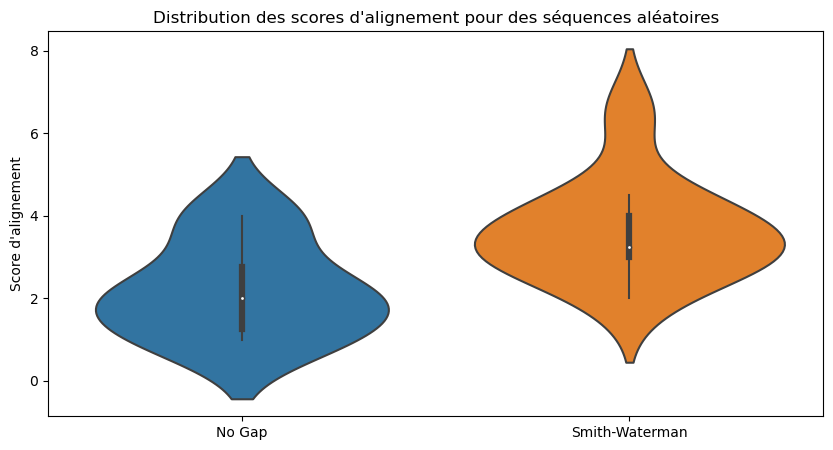

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

R = 10
N = 10

nucl = ['A', 'T', 'G', 'C']
probs = [0.25, 0.25, 0.25, 0.25]

def generateRandomSequences(R, N):
    return [(''.join(np.random.choice(nucl, N, p=probs)), ''.join(np.random.choice(nucl, N, p=probs))) for i in range(R)]

def scoreNoGap(x,y):
    return sum(1 for a, b in zip(x,y) if a == b)

rand = generateRandomSequences(R, N)
nogap = [scoreNoGap(x,y) for x,y in rand]

scores = []
for x,y in rand:
    S, B, _ = sw_fwd(x,y, rmap, sigma, go, ge)
    _, _, score = sw_bwd(x,y, S, B)
    scores.append(score)

plt.figure(figsize=(10, 5))
sns.violinplot(data=[nogap, scores], inner='box')
plt.xticks([0, 1], ['No Gap', 'Smith-Waterman'])
plt.ylabel("Score d'alignement")
plt.title("Distribution des scores d'alignement pour des séquences aléatoires")
plt.show()

Q3. Qu'observez-vous ?

```markdown
Le score d'alignement semble plus élevé avec l'alignement Smith-Waterman.
```

Q4. Quelle conclusion peut-on en tirer sur la significativité d'un alignement ?

```markdown
Plus le score d'un alignement est élevé plus la correspondance est proche, et l'alignement Smith-Waterman compare de manière plus pertinentes les données car il se focalise sur les parties les plus similaires.
```